# WORKSHOP 2

------------

GRUPO 4:

Digital House

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('properatti.csv')
Dicto = {}

In [3]:
def data_info(data, name='data'):
    df = pd.DataFrame(pd.Series(data.columns))
    df.columns = ['columna']
    df.columns.name = f'df de {name}'
    df.index.name = 'index'
    df['Nan'] = data.isna().sum().values
    df['dtype']  = data.dtypes.values
    df['count'] = data.count().values
    df['pct_nan'] = round(df['Nan']/data.shape[0]*100,2)
    df['count_unique'] = [len(data[elemento].value_counts()) for elemento in data.columns]
    return df

def explore_count(frame, label_1):
    df = pd.DataFrame(index = pd.Series(frame[label_1].unique()))
    frame['all_one'] = 1
    #cantidad de datos publicados
    df = df.join(frame.groupby(label_1)['all_one'].count())
    df.columns = ['total']
    frame.drop('all_one', axis=1, inplace=True)
    return df

def explore_count_by(frame,label_1, label_2, df):
    # cantidad de tipo apartment
    set_check = list(set(frame[label_2]))
    frame['all_one'] = 1
    for i,propiedad in enumerate(set_check):
        serie_check =frame[frame[label_2]==propiedad].groupby(label_1)['all_one'].count()
        df['count_'+propiedad] = 0 + serie_check
    frame.drop('all_one', axis=1, inplace=True)
    return df

def explore_statics_count(frame, label_1, label_2, label_3, df):
    # precio promedio y la mediana de precio para state_name, property_type
    data_check = frame.groupby([label_1, label_2])[label_3].aggregate(['mean', 'std', 'median'])
    data_check.reset_index(inplace=True)
    data_check = data_check.pivot_table(index=label_1, columns=label_2)
    set_check = list(set(data[label_2]))
    for propiedad in set_check:
        df[propiedad+'_mean_'+label_3] = 0 + data_check.loc[:]['mean'][propiedad]
        df[propiedad+'_std_'+label_3] = 0 + data_check.loc[:]['std'][propiedad]
        df[propiedad+'_median_'+label_3] = 0 + data_check.loc[:]['median'][propiedad]
    # dispersion de los precios
    for propiedad in set_check:
        df['CV_'+propiedad+'_'+label_3] = df[propiedad+'_std_'+label_3]/df[propiedad+'_mean_'+label_3]
    return df

def rango_extremos(frame, label, quant_list):
        for i,v in enumerate(quant_list):
            quant_list[i] = v /100
        
        rango_outlier = frame[label].quantile(quant_list)
        rango_outlier = list(rango_outlier)
        print ('range_outlier: type: {}, len: {}, value: {}'.format(type(rango_outlier),len(rango_outlier),rango_outlier))
        return rango_outlier
    
def mascara_outlier_index_list(frame, label, rango_outlier): # el problema que tengo es sacarme solo True de encima y quedarme con el indice de los False - 
    mascara_outlier = (frame[label].dropna() >= rango_outlier[0]) & (frame[label].dropna() <= rango_outlier[1])  #ME QUEDO CON EL RANGO FALSE
    #resulta: mascara booleana quiero quedarme con el indice de los False
    lista_elementos = mascara_outlier.values
    lista_indices = mascara_outlier.index
    lista_elementos = list(lista_elementos)
    lista_indices = list(lista_indices)
    lista_result = []
    for i, booleano in enumerate(lista_elementos):
        if booleano == False:
            lista_result.append(lista_indices[i])
    return lista_result

def check_range(frame, label, rango):
    mask_data = (frame[label] <= rango[0]) | (frame[label] >= rango[1])  # tomo True los valores que caen fuera del rango
    # necesito solo los indices que sean True
    lista_elementos = list(mask_data.values)
    lista_indices = list(mask_data.index)
    lista_result = []
    for i, booleano in enumerate(lista_elementos):
        if booleano == True:
            lista_result.append(lista_indices[i])
    return lista_result

def cambia_nombre_columnas(data=data, **kwarg):
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html
    for key in kwarg.keys():
        data.rename(kwarg[key], axis=1, inplace=True)
    return data

def cambia_orden_columnas(check_list, data=data, safe=1): # safe: es para conservar la primera columna con indice[0]
    label_list = list(data.columns)
    for i in range(len(check_list)):
        label_list.remove(check_list[i])
        label_list.insert(i+safe, check_list[i])
        data = data.reindex(label_list, axis=1)
    return data

In [4]:
# 1. COLUMNAS REDUNDANTES
# 1.1 Recupero datos colgados
data.loc[data.place_name.isna(),'place_name'] = 'Tigre'
# 1.2 COLUMNAS DE TRABAJO
columnas = ['property_type', 'place_name', 'state_name', 'price', 'currency', 'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2']
data = data.filter(columnas, axis=1)
# 1.3 GUARADADO DE LOS DATOS CRUDOS
df = data_info(data, 'data_cruda')
Dicto['data_cruda'] = df.to_dict(), data.to_dict()

# 2. ANALISIS DE COTIZACION
# 2.1: creacion de una columna soporte de superficie
mask_data = data.surface_total_in_m2.notna() & data.surface_covered_in_m2.notna()
mask_data = data[mask_data].surface_total_in_m2 >= data[mask_data].surface_covered_in_m2 # comprobamos que haya logica Total > Cubierto
data['surface_total_in_m2'].fillna(0, inplace=True)
data['surface_covered_in_m2'].fillna(0, inplace=True)
data['surface_total_in_m2_mod'] = np.maximum(data.surface_total_in_m2, data.surface_covered_in_m2)
data['surface_total_in_m2_mod'] = data['surface_total_in_m2_mod'].replace(0,np.nan)
data['surface_total_in_m2'] = data['surface_total_in_m2'].replace(0,np.nan)
data['surface_covered_in_m2'] = data['surface_covered_in_m2'].replace(0,np.nan)

# 2.2 #comprobamos que hay valores ilogicos porque price_usd_per_m2 es mayor a price_per_m2 que esta en pesos
mask_data = data.currency == 'ARS'
data.drop((data[mask_data].loc[data.price_per_m2 < data.price_usd_per_m2]).index, inplace=True)

# 2.3: DEFINICION DEL TIPO DE CAMBIO
tc = np.mean(data.price_aprox_local_currency/data.price_aprox_usd) # tc promedio 17.6444

# 2.4: PASAR LA COLUMNA price A UN SOLO TIPO DE CAMBIO
mask_data = data.currency == 'ARS'
data.loc[mask_data, 'price'] = data[mask_data].price / tc
data.loc[mask_data, 'currency'] = 'USD'
mask_data = data.loc[:,'currency'] != 'USD'
mask_data = data.loc[mask_data,'currency'].dropna().index
data.drop(mask_data, inplace=True)

# 2.5: ELIMINAMOS 870 VALORES INCOHERENTES Y RECUPERO DE PRICE_USD_PER_M2
data['price_usd_per_m2_recovery'] = data['price'] / data['surface_total_in_m2_mod']
data['diff_pct_change'] = (data['price_usd_per_m2_recovery'] / data['price_usd_per_m2'] -1 )*100
# ' Elimino del dataset de trabajo los que tenian desvios de +- 4.75%'
mask_data = data.loc[(data['diff_pct_change'] < -4.75) | (data['diff_pct_change'] > 4.75)].index
data.drop(mask_data, inplace=True)
data['price_usd_per_m2'].fillna(data['price_usd_per_m2_recovery'], inplace=True)

# 3 REACONDICIONAMIENTO DEL DATA
columnas = ['diff_pct_change','price_usd_per_m2_recovery', 'surface_total_in_m2_mod', 'price_aprox_usd', 'price_per_m2', 'price_aprox_local_currency']
data.drop(columnas, axis=1, inplace=True)
    
# 3.1: TOMAMOS MUESTRA DE LOS CURRENCY NANS
df = data_info(data[data.currency.isna()], 'currency_nan')
Dicto['currency_nan'] = df.to_dict(), data[data.currency.isna()].to_dict()

# 3.2: TOMAMOS MUESTRA DE SURFACE_COVERED ISNA() Y SURFACE_TOTAL ISNA()
mask_1 = data.surface_total_in_m2.isna()
mask_2 = data.surface_covered_in_m2.isna()
df = data_info(data[mask_1 & mask_2], 'surface_nan')
Dicto['surface_nan'] = df.to_dict(), data[mask_1 & mask_2].to_dict()

# 3.3 GUARDADO DE LA DATA
data = data.drop(data[mask_1 & mask_2].index)
data = data.drop(data[data.currency.isna()].index)

df = data_info(data, 'limpieza_1')
Dicto['limpieza_1'] = df.to_dict(), data.to_dict()

In [5]:
# SE CREA UNA COLUMNA QUE NOS DA UN GRADO DE CORRELACION ENTRE SUPERFICIE CUBIERTA Y PRECIO, SIEMPRE QUE EL VALOR SEA CERCANO A 1

data['surface_covered_price_index'] = data.price/(data.surface_covered_in_m2 * data.price_usd_per_m2)
data['surface_total'] = data.price/(data.surface_total_in_m2 * data.price_usd_per_m2)

display (data[['surface_covered_price_index', 'surface_total']].describe()[:3])
data.drop('surface_total', axis=1, inplace=True)
# (!) podemos conservar los valores cercanos a 1 surface_covered

,surface_covered_price_index,surface_total
count,86792.000000,67751.000000
mean,1.593515,1.001148
std,13.044843,0.003890


In [6]:
# 4. LIMPIEZA POR COUNTS
# 4.1 LIMPIEZA POR STATE_NAME EN FUNCION DEL COUNT: NOS QUEDAMOS CON LAS 7 PROVINCIAS/LOCALIDADES CON MAYOR CANTIDAD DE PUBLICACIONES
df = explore_count(data, 'state_name');
df.sort_values(by='total', ascending=False, inplace=True)
lista_state = list(df.index)[:8]
lista = []
for elemento in lista_state:
    lista.append(list(data[data.state_name == elemento].index))
lista_mascara = []
for elemento in lista:
    lista_mascara += elemento

data = data.filter(lista_mascara, axis=0)

# 4.2 LIMPIEZA POR PLACE_NAME EN FUNCION DEL COUNT: NOS QUEDAMOS CON LAS CIUDADES/BARRIOS QUE TENGAN MAS DE 45 PUBLICACIONES \ check:<#df.total.value_counts().to_frame().reset_index().sort_values(by = 'index', ascending=True).head(50)>
lista_filter = []
for ix, state in enumerate(lista_state):
    mascara_iteracion = data.state_name == state
    df = explore_count(data[data.state_name == state], 'place_name');
    mask = df.total > 45
    lista_city = list(df[mask].index)

    lista = []
    for elemento in lista_city:
        lista.append(list(data[mascara_iteracion].loc[data.place_name == elemento].index))

    lista_mascara = []
    for elemento in lista:
        lista_mascara += elemento
    
    lista_filter += lista_mascara
        
data = data.filter(lista_filter, axis=0)

# 4.3 GUARDADO DE LA DATA
df = data_info(data, 'limpieza_2')
Dicto['limpieza_2'] = df.to_dict(), data.to_dict()

C:\Users\aguST\AppData\Local\Temp/ipykernel_9660/225816664.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['all_one'] = 1
C:\Users\aguST\anaconda3\envs\dhdsblend2021\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\aguST\AppData\Local\Temp/ipykernel_9660/225816664.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [7]:
# CREACION DE DATAFRAME PRICE
df = explore_count(data, 'place_name')
df = explore_count_by(data, 'place_name', 'property_type', df)
df = explore_statics_count(data,'place_name', 'property_type','price_usd_per_m2',df)

#  # FILTROS # #
#nomenclatura: el primer numero hace reperenfencia al tipo de propiedad, y el segundo hace referencia a la cantidad de filtros que lleva implementandose
filtro_1_1 = list(df.columns)[:2]
filtro_2_1 = list(df.columns)[:3:2]
filtro_3_1 = list(df.columns)[:4:3]
filtro_4_1 = list(df.columns)[:5:4]


filtro_1_2 = list(df.columns)[5:8]
filtro_2_2 = list(df.columns)[8:11]
filtro_3_2 = list(df.columns)[11:14]
filtro_4_2 = list(df.columns)[14:17]


filtro_1_3 = list(df.columns)[17:18]
filtro_2_3 = list(df.columns)[18:19]
filtro_3_3 = list(df.columns)[19:20]
filtro_4_3 = list(df.columns)[20:21]


filtro_1 = filtro_1_1 + filtro_1_2 + filtro_1_3
filtro_2 = filtro_2_1 + filtro_2_2 + filtro_2_3
filtro_3 = filtro_3_1 + filtro_3_2 + filtro_3_3
filtro_4 = filtro_4_1 + filtro_4_2 + filtro_4_3

lista_filtros = [filtro_1, filtro_2, filtro_3, filtro_4]

# # CATEGORIZACION # #
# Se crea la columna low_coeficiente_variacion = std/mean
diccionario_prop_type_low_cv = {}

for filtro in lista_filtros: 
    label = str(list(df.loc[:,filtro].columns)[1])
    label = label.replace('count_', '')
    df['LowCV_' + label] = df.loc[:,filtro].eval(str(list(df.loc[:,filtro].columns)[-1])+' < 0.99') #creacion de columna categorica
    mask = df['LowCV_' + label] == True
    diccionario_prop_type_low_cv[label] = list(df.loc[mask,filtro].index)
    
# # FILTRADO # #
# En base a la categoria obtenida se aplica el método de filtrado
set_check = set(list(data.property_type))
lista_dict = list(diccionario_prop_type_low_cv.keys())
lista_filter = []
lista_mascara = []

for ix, propiedad in enumerate(set_check):
    if propiedad == lista_dict[ix]:
        lista_city = diccionario_prop_type_low_cv[propiedad]
        lista = []
        mascara = data.property_type == propiedad
        
        for elemento in lista_city:
            lista.append(list(data.loc[mascara].loc[data.place_name==elemento].index)) # estamos hablando que el tipo de propiedad en la localidad especifica tiene bajos CV, y me quedo con los index

        lista_mascara += lista
for elemento in lista_mascara:
    lista_filter += elemento

data = data.filter(lista_filter, axis=0)

# # GUARDADO DE LA DATA # # 
df = data_info(data, 'data_price')
Dicto['data_price'] = df.to_dict(), data.to_dict()

In [8]:
# CREACION DE DATAFRAME SUPERFICIE TOTAL (solo hubo que cambiar 3 palabras respecto a la celda anterior)
data = pd.DataFrame(Dicto['limpieza_2'][1])

df = explore_count(data, 'place_name')
df = explore_count_by(data, 'place_name', 'property_type', df)
df = explore_statics_count(data,'place_name', 'property_type','surface_total_in_m2',df)

#  # FILTROS # #
#nomenclatura: el primer numero hace reperenfencia al tipo de propiedad, y el segundo hace referencia a la cantidad de filtros que lleva implementandose
filtro_1_1 = list(df.columns)[:2]
filtro_2_1 = list(df.columns)[:3:2]
filtro_3_1 = list(df.columns)[:4:3]
filtro_4_1 = list(df.columns)[:5:4]


filtro_1_2 = list(df.columns)[5:8]
filtro_2_2 = list(df.columns)[8:11]
filtro_3_2 = list(df.columns)[11:14]
filtro_4_2 = list(df.columns)[14:17]


filtro_1_3 = list(df.columns)[17:18]
filtro_2_3 = list(df.columns)[18:19]
filtro_3_3 = list(df.columns)[19:20]
filtro_4_3 = list(df.columns)[20:21]


filtro_1 = filtro_1_1 + filtro_1_2 + filtro_1_3
filtro_2 = filtro_2_1 + filtro_2_2 + filtro_2_3
filtro_3 = filtro_3_1 + filtro_3_2 + filtro_3_3
filtro_4 = filtro_4_1 + filtro_4_2 + filtro_4_3

lista_filtros = [filtro_1, filtro_2, filtro_3, filtro_4]

# # CATEGORIZACION # #
# Se crea la columna low_coeficiente_variacion = std/mean
diccionario_prop_type_low_cv = {}

for filtro in lista_filtros: 
    label = str(list(df.loc[:,filtro].columns)[1])
    label = label.replace('count_', '')
    df['LowCV_' + label] = df.loc[:,filtro].eval(str(list(df.loc[:,filtro].columns)[-1])+' < 0.99') #creacion de columna categorica
    mask = df['LowCV_' + label] == True
    #Dicto
    diccionario_prop_type_low_cv[label] = list(df.loc[mask,filtro].index)
    
# # FILTRADO # #
# En base a la categoria obtenida se aplica el método de filtrado
set_check = set(list(data.property_type))
lista_dict = list(diccionario_prop_type_low_cv.keys())
lista_filter = []
lista_mascara = []

for ix, propiedad in enumerate(set_check):
    if propiedad == lista_dict[ix]:
        lista_city = diccionario_prop_type_low_cv[propiedad]
        lista = []
        mascara = data.property_type == propiedad
        
        for elemento in lista_city:
            lista.append(list(data.loc[mascara].loc[data.place_name==elemento].index)) 

        lista_mascara += lista
for elemento in lista_mascara:
    lista_filter += elemento

data = data.filter(lista_filter, axis=0)

# # GUARDADO DE LA DATA # # 
df = data_info(data, 'data_surface')
Dicto['data_surface'] = df.to_dict(), data.to_dict()

In [9]:
df = data_info(data)
display (df)

df = data_info(pd.DataFrame(Dicto['data_price'][1]))
df

df de data,columna,Nan,dtype,count,pct_nan,count_unique
index,,,,,,
0,property_type,0,object,53142,0.00,4
1,place_name,0,object,53142,0.00,191
2,state_name,0,object,53142,0.00,8
3,price,0,float64,53142,0.00,6159
4,currency,0,object,53142,0.00,1
5,surface_total_in_m2,13204,float64,39938,24.85,1097
6,surface_covered_in_m2,2160,float64,50982,4.06,691
7,price_usd_per_m2,0,float64,53142,0.00,19612
8,surface_covered_price_index,2160,float64,50982,4.06,9121


df de data,columna,Nan,dtype,count,pct_nan,count_unique
index,,,,,,
0,property_type,0,object,38919,0.00,4
1,place_name,0,object,38919,0.00,181
2,state_name,0,object,38919,0.00,8
3,price,0,float64,38919,0.00,4954
4,currency,0,object,38919,0.00,1
5,surface_total_in_m2,8568,float64,30351,22.01,949
6,surface_covered_in_m2,2495,float64,36424,6.41,670
7,price_usd_per_m2,0,float64,38919,0.00,15196
8,surface_covered_price_index,2495,float64,36424,6.41,6833



 ======================================== pct_nan: evolucion imputaje de nans ======================================== 



<BarContainer object of 9 artists>

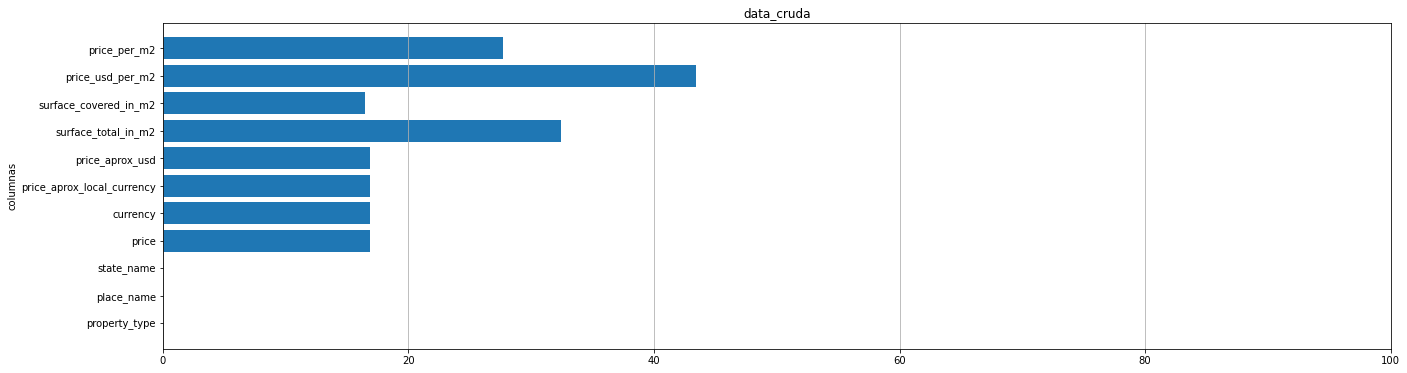

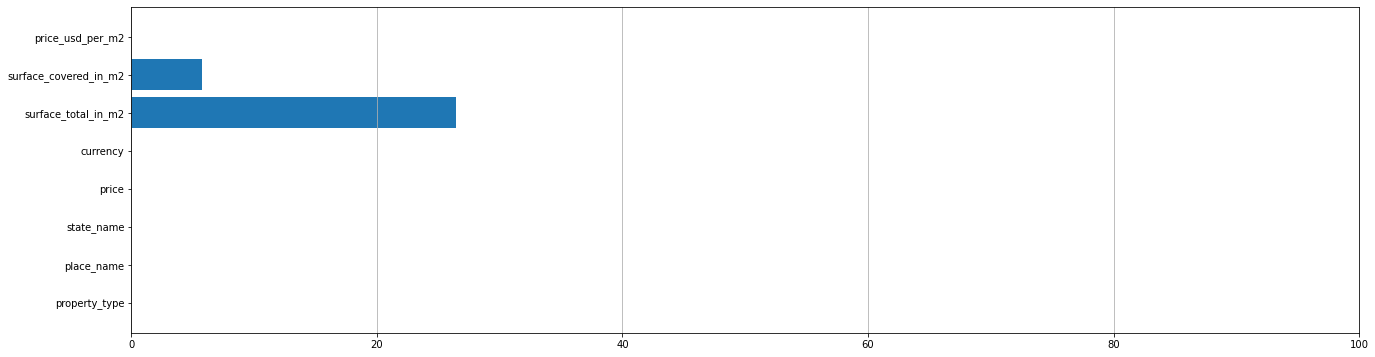

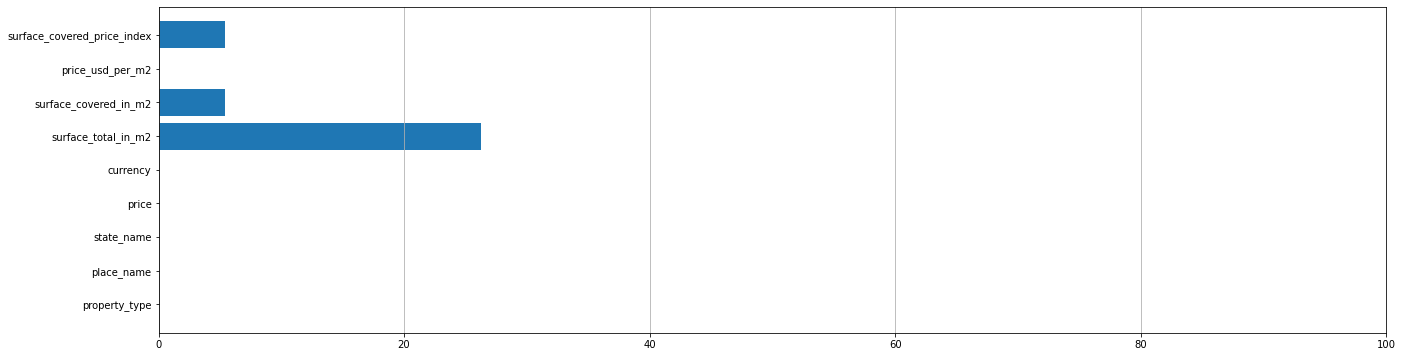

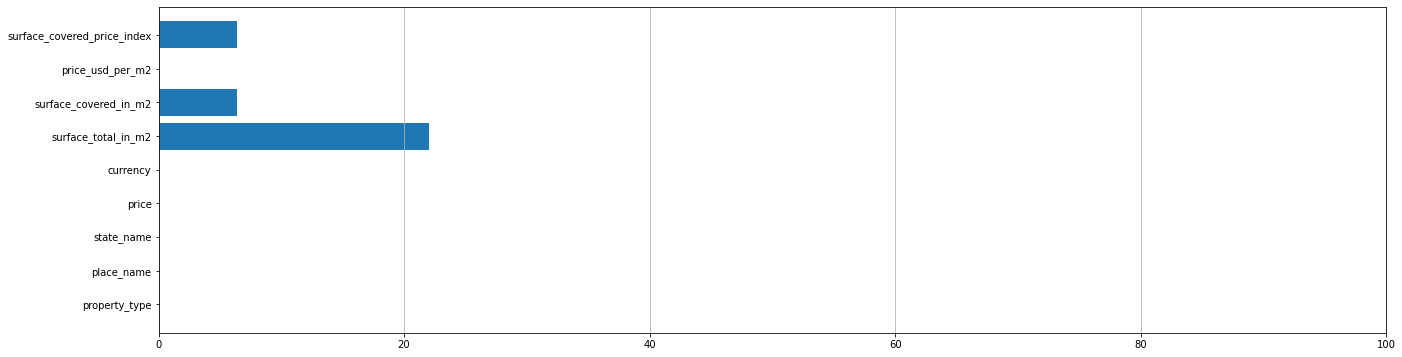

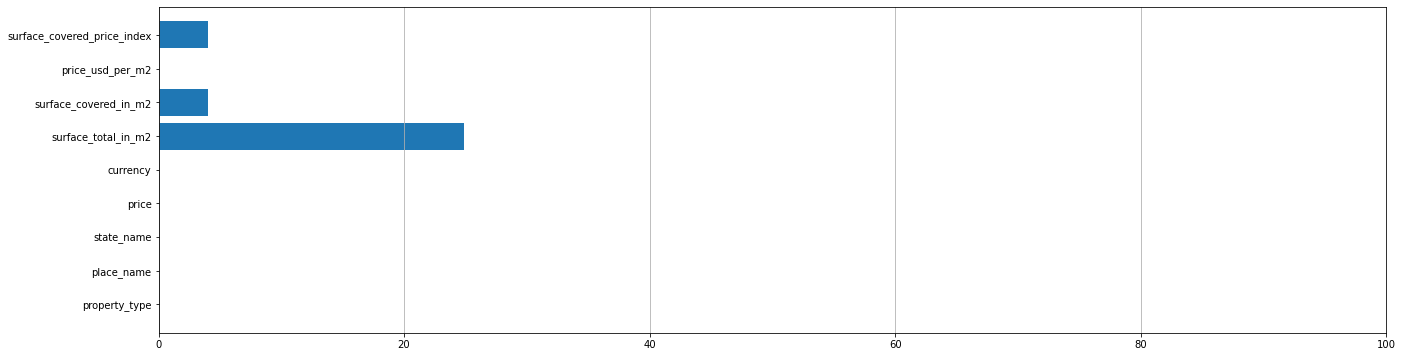

In [10]:
print ('\n', '='*40,'pct_nan: evolucion imputaje de nans','='*40, '\n')

df = pd.DataFrame(Dicto['data_cruda'][0])
fig, ax = plt.subplots(figsize=(22, 6))
ax.grid(axis='x')
ax.set(xlim=(0, 100), ylabel='columnas', title='data_cruda')
axes= plt.gca()
#axes.set_xlim(0,100)
plt.barh(df.columna, df.pct_nan, label='porcentaje de NaN\'s')

df = pd.DataFrame(Dicto['limpieza_1'][0])
fig, ax = plt.subplots(figsize=(22, 6))
ax.grid(axis='x')
axes= plt.gca()
axes.set_xlim(0,100)
plt.barh(df.columna, df.pct_nan, label='porcentaje de NaN\'s')

df = pd.DataFrame(Dicto['limpieza_2'][0])
fig, ax = plt.subplots(figsize=(22, 6))
ax.grid(axis='x')
axes= plt.gca()
axes.set_xlim(0,100)
plt.barh(df.columna, df.pct_nan, label='porcentaje de NaN\'s')

############## COMPARACION ####################
df = pd.DataFrame(Dicto['data_price'][0])
fig, ax = plt.subplots(figsize=(22, 6))
ax.grid(axis='x')
axes= plt.gca()
axes.set_xlim(0,100)
plt.barh(df.columna, df.pct_nan, label='porcentaje de NaN\'s')

df = pd.DataFrame(Dicto['data_surface'][0])
fig, ax = plt.subplots(figsize=(22, 6))
ax.grid(axis='x')
axes= plt.gca()
axes.set_xlim(0,100)
plt.barh(df.columna, df.pct_nan, label='porcentaje de NaN\'s')

-------------
OBSERVAMOS QUE **data_price** nos disminuye los nans en surface_total por lo que optamos por dicha propuesta

------------


 ======================================== price_per_m2: distribucion boxplot ========================================


C:\Users\aguST\anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\aguST\anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


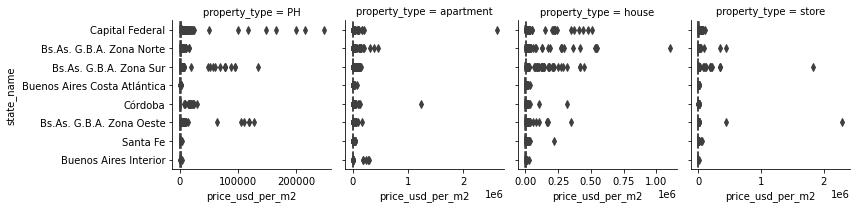

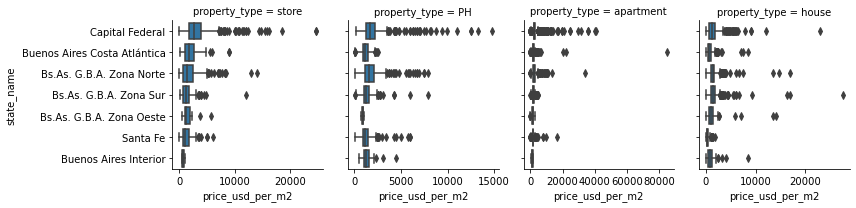

In [11]:
# VERSION ANTERIOR
print ('\n', '='*40,'price_per_m2: distribucion boxplot','='*40)

g = sns.FacetGrid(pd.DataFrame(Dicto['limpieza_2'][1]), col="property_type", margin_titles=True, sharex=False)
g.map(sns.boxplot, 'price_usd_per_m2', 'state_name');

g = sns.FacetGrid(pd.DataFrame(Dicto['data_price'][1]), col="property_type", margin_titles=True, sharex=False)
g.map(sns.boxplot, 'price_usd_per_m2', 'state_name');

COMPARACION PRECIO CON SUPERFICIE CUBIERTA


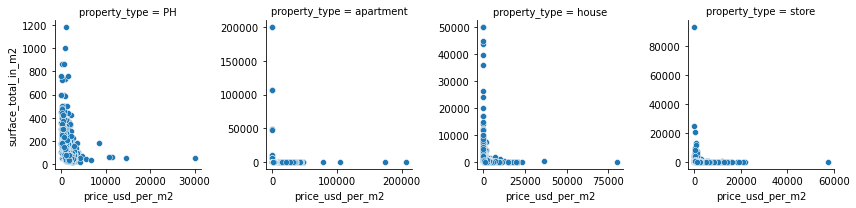

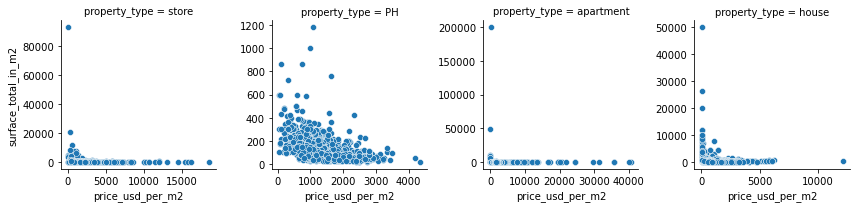

In [12]:
print ('COMPARACION PRECIO CON SUPERFICIE CUBIERTA')
g = sns.FacetGrid(pd.DataFrame(Dicto['limpieza_2'][1]), col="property_type", margin_titles=True, sharex = False, sharey=False)
g.map(sns.scatterplot, 'price_usd_per_m2','surface_total_in_m2')

g = sns.FacetGrid(pd.DataFrame(Dicto['data_price'][1]), col="property_type", margin_titles=True, sharex = False, sharey=False)
g.map(sns.scatterplot, 'price_usd_per_m2','surface_total_in_m2')

Text(0.5, 0, 'ACTUAL')

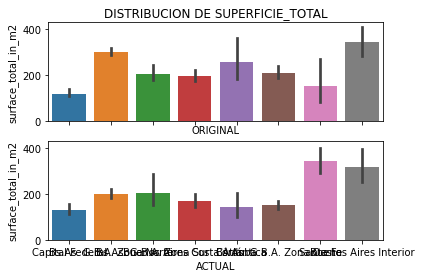

In [13]:
data_check = pd.DataFrame(Dicto['limpieza_2'][1])

data = pd.DataFrame(Dicto['data_price'][1])
df = pd.DataFrame(Dicto['data_price'][0])


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)

#ax1.set()
sns.barplot(x=data_check.state_name, y=data_check.surface_total_in_m2, ax=ax1)
sns.barplot(x=data.state_name, y=data.surface_total_in_m2, ax=ax2)


ax1.set_title('DISTRIBUCION DE SUPERFICIE_TOTAL')
ax1.set_xlabel('ORIGINAL')
ax2.set_xlabel('ACTUAL')

In [14]:
# 5. ELIMINACION DE OUTLIERS POR SURFACE_COVERED_IN_M2
print ('EXCLUSION DE OUTLIERS SUPERFICIE')

data_aux = data.copy()
lista = [data_aux, data]

lista_rangos_main = []
lista_drops_main = []

for ix, data_sup in enumerate(lista):
    
    serie_check = data_sup.property_type
    set_check = set(list(serie_check))
    lista_rangos = []
    lista_drops = []
    #IF IX IMPRIMIR EL DATASET QUE ESTOY TRABAJANDO
    for i,elemento in enumerate (set_check):
        print ('-----------------\nIteracion en {}\n-----------------'.format(elemento))
        mascara_iter_1 = serie_check == elemento
        
        if ix == 1: #data
            if elemento == 'house':
                rango_outlier = rango_extremos(data_sup.loc[mascara_iter_1], 'surface_total_in_m2', [0.1, 96])
            if elemento == 'apartment':
                rango_outlier = rango_extremos(data_sup.loc[mascara_iter_1], 'surface_total_in_m2', [0.1, 96])
            if elemento == 'store':
                rango_outlier = rango_extremos(data_sup.loc[mascara_iter_1], 'surface_total_in_m2', [0.1, 96])
            if elemento == 'PH':
                rango_outlier = rango_extremos(data_sup.loc[mascara_iter_1], 'surface_total_in_m2', [0.1, 98])
                
        if ix==0:# data_aux
            if elemento == 'PH':
                rango_outlier = rango_extremos(data_sup.loc[mascara_iter_1], 'surface_covered_in_m2', [1, 99])
            else:
                rango_outlier = rango_extremos(data_sup.loc[mascara_iter_1], 'surface_covered_in_m2', [2.5, 97.5])
    
        lista_rangos.append(rango_outlier)
# IMPUTACION COLUMNA        
        if ix == 0:
            serie_outlier = data_sup.surface_total_in_m2.loc[mascara_iter_1]
            mask_data = data_sup.loc[serie_outlier.index, 'surface_total_in_m2'].dropna()
            indice_outlier = mascara_outlier_index_list(data_sup.loc[mask_data.index], 'surface_total_in_m2', rango_outlier)    
        if ix == 1:
            serie_outlier = data_sup.surface_total_in_m2.loc[mascara_iter_1]
            mask_data = data_sup.loc[serie_outlier.index, 'surface_total_in_m2'].dropna()
            indice_outlier = mascara_outlier_index_list(data_sup.loc[mask_data.index], 'surface_total_in_m2', rango_outlier)    
        
        lista_drops.append(indice_outlier)

    lista_rangos_main.append(lista_rangos)   
    lista_drops_main.append(lista_drops)
    for lista_indices in lista_drops:
        data_sup.drop(lista_indices, inplace=True)

    print ('--------------------------------------------------------------------------------\n')#Dataset final:')    
    lista[ix] = data_sup

df = data_info(lista[0], 'limpieza_3')
Dicto['limpieza_3'] = df.to_dict(), lista[0].to_dict()

df = data_info(lista[1], 'without_outliers_surface')
data = lista[1]
Dicto['w_out_surface'] = df.to_dict(), lista[1].to_dict()    
    
# 6. RECUPERACION DE DATOS SURFACE_COVERED:

print ('\nRECUPERO DATA: surface_covered_in_m2\n')
print ('\nOUTLIER DE DATA RECUPERADA\n')
for ix, data_sup in enumerate(lista):
    data_sup['surface_recovery'] = data_sup['price'] / data_sup['price_usd_per_m2']

    serie_check = data_sup['surface_recovery']
    serie_check.dropna(inplace=True)
    mask_data = data_sup.surface_total_in_m2.isna()
            
    for i, propiedad in enumerate(set_check):
        data_check = data_sup.loc[mask_data].loc[mascara_iter_1]
        lista_drop = check_range(data_check, 'surface_recovery', lista_rangos_main[ix][i])
    
        data_sup.drop(lista_drop, inplace=True)
   
    # GUARDADO DE LA DATA    
    data_sup.surface_covered_in_m2.fillna(data_sup.surface_recovery, inplace=True)
    data_sup.drop('surface_recovery', axis=1, inplace=True)

    lista[ix] = data_sup

df = data_info(lista[0],'limpieza_3_aux')    
Dicto['limpieza_3_aux'] = df.to_dict(), lista[0].to_dict()

data = lista[1]

EXCLUSION DE OUTLIERS SUPERFICIE
-----------------
Iteracion en store
-----------------
range_outlier: type: <class 'list'>, len: 2, value: [18.900000000000002, 2700.0]
-----------------
Iteracion en PH
-----------------
range_outlier: type: <class 'list'>, len: 2, value: [20.0, 274.0]
-----------------
Iteracion en apartment
-----------------
range_outlier: type: <class 'list'>, len: 2, value: [25.0, 215.0]
-----------------
Iteracion en house
-----------------
range_outlier: type: <class 'list'>, len: 2, value: [56.650000000000006, 560.0]
--------------------------------------------------------------------------------

-----------------
Iteracion en store
-----------------
range_outlier: type: <class 'list'>, len: 2, value: [11.824, 1529.119999999999]
-----------------
Iteracion en PH
-----------------
range_outlier: type: <class 'list'>, len: 2, value: [21.886000000000003, 329.1399999999999]
-----------------
Iteracion en apartment
-----------------
range_outlier: type: <class 'list


 ======================================== pct_nan: evolucion imputaje de nans ======================================== 



<BarContainer object of 9 artists>

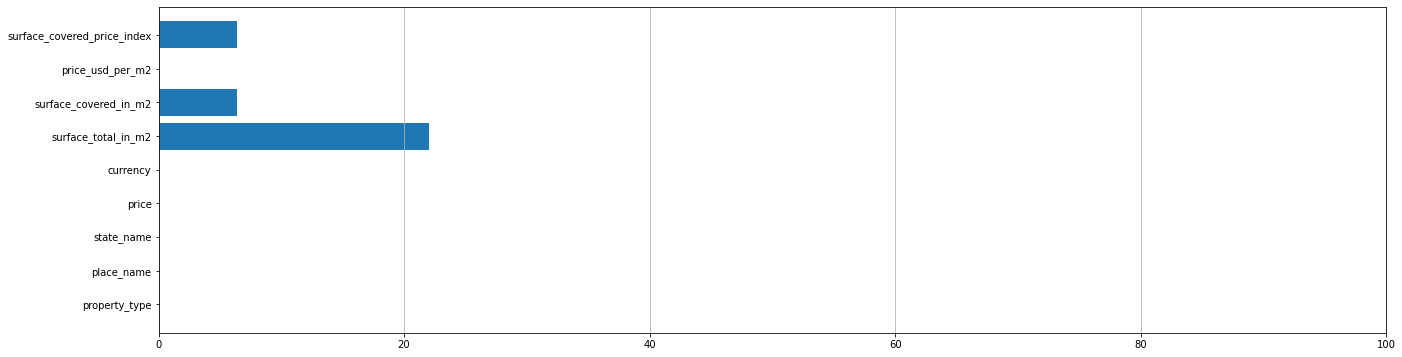

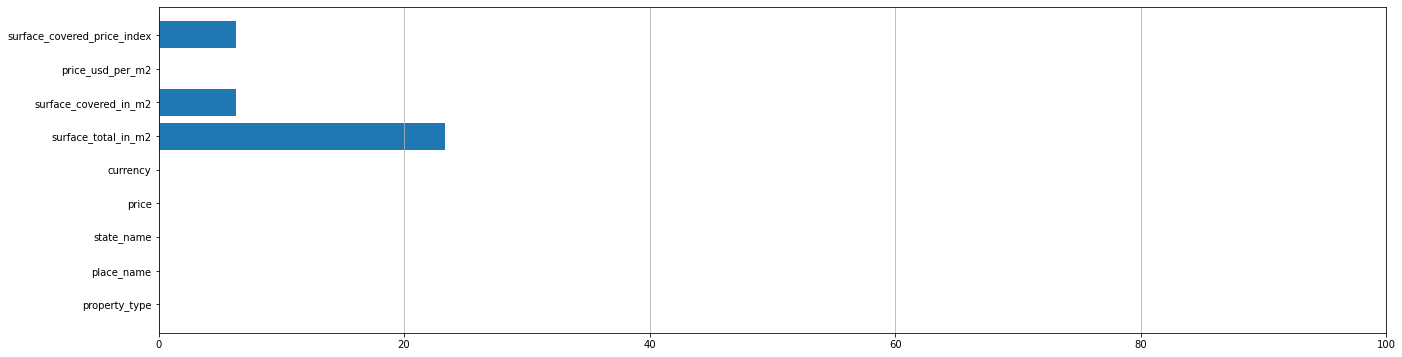

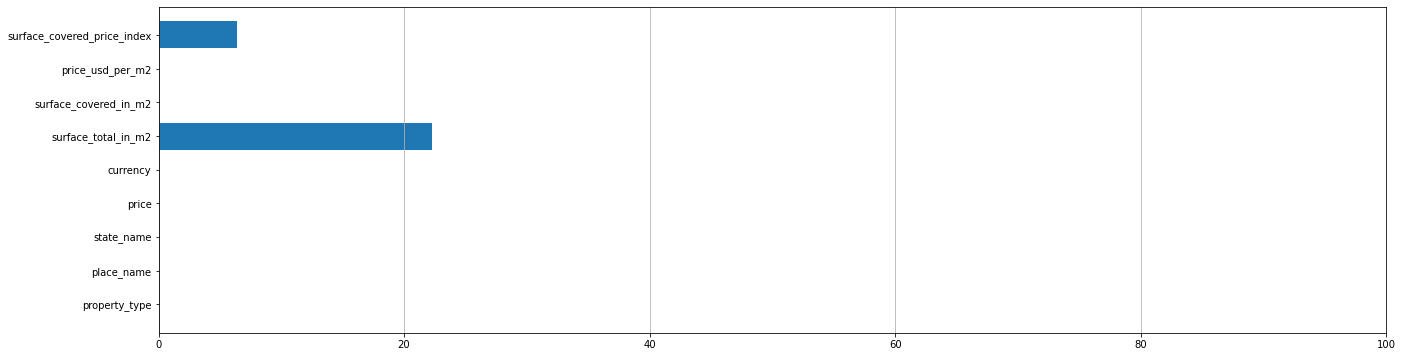

In [15]:
print ('\n', '='*40,'pct_nan: evolucion imputaje de nans','='*40, '\n')

df = pd.DataFrame(Dicto['data_price'][0])
fig, ax = plt.subplots(figsize=(22, 6))
ax.grid(axis='x')
axes= plt.gca()
axes.set_xlim(0,100)
plt.barh(df.columna, df.pct_nan, label='porcentaje de NaN\'s')

df = pd.DataFrame(Dicto['limpieza_3'][0])
fig, ax = plt.subplots(figsize=(22, 6))
ax.grid(axis='x')
axes= plt.gca()
axes.set_xlim(0,100)
plt.barh(df.columna, df.pct_nan, label='porcentaje de NaN\'s')

df = data_info(lista[0])
fig, ax = plt.subplots(figsize=(22, 6))
ax.grid(axis='x')
axes= plt.gca()
axes.set_xlim(0,100)
plt.barh(df.columna, df.pct_nan, label='porcentaje de NaN\'s')

,surface_covered_price_index,surface_total
count,37230.000000,29158.000000
mean,1.197117,1.000552
std,1.680687,0.002724


<BarContainer object of 9 artists>

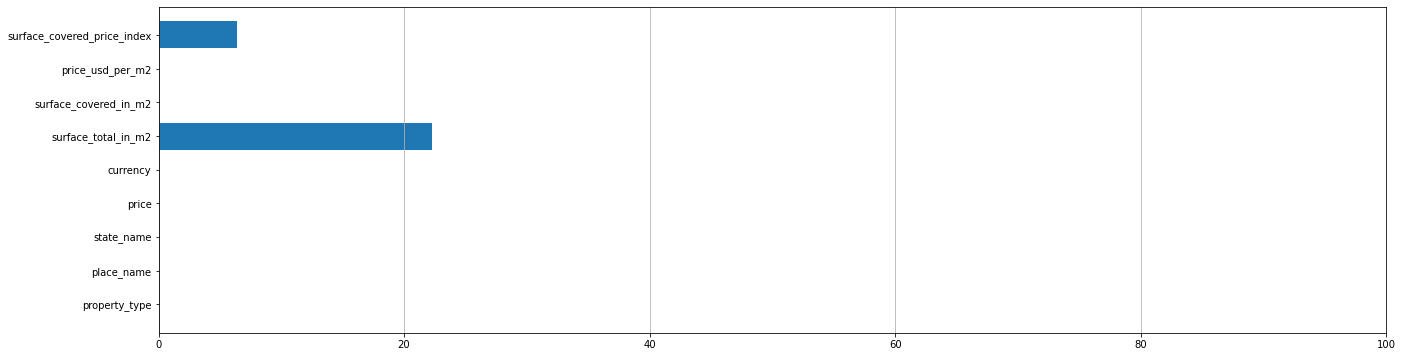

In [16]:
# SE CREA UNA COLUMNA QUE NOS DA UN GRADO DE CORRELACION ENTRE SUPERFICIE CUBIERTA Y PRECIO, SIEMPRE QUE EL VALOR SEA CERCANO A 1

data['surface_covered_price_index'] = data.price/(data.surface_covered_in_m2 * data.price_usd_per_m2)
data['surface_total'] = data.price/(data.surface_total_in_m2 * data.price_usd_per_m2)

display (data[['surface_covered_price_index', 'surface_total']].describe()[:3])
data.drop('surface_total', axis=1, inplace=True)

df = data_info(lista[0])
fig, ax = plt.subplots(figsize=(22, 6))
ax.grid(axis='x')
axes= plt.gca()
axes.set_xlim(0,100)
plt.barh(df.columna, df.pct_nan, label='porcentaje de NaN\'s')

In [17]:
# 7 ELIMINACION DE OUTLIERS DE PRICE
print ('EXCLUSION DE OUTLIERS PRICE\n') #APLICAR OUTLIERS EN PRICE PERO NO EN EL TIPO DE CATEGORIA PH, CORTAMOS SOLO LA COLA DERECHA AL 1%, APLICAR A LOS DOS DATASETS

data_aux = pd.DataFrame(Dicto['data_price'][1])
lista = [data_aux, data]

for ix, data_sup in enumerate(lista):
    
    serie_check = data_sup.property_type
    set_check = set(list(serie_check))
    lista_rangos = []
    lista_drops = []
    
    for i,elemento in enumerate (set_check):
        #print ('--------------\nITERACION N: {}\n--------------'.format(elemento))
        mascara_iter_1 = serie_check == elemento
        
        if ix == 1: #data
            if elemento == 'PH':
                rango_outlier = rango_extremos(data_sup.loc[mascara_iter_1], 'price_usd_per_m2', [0.01, 99.9])
            if elemento == 'apartment' or elemento == 'store':
                rango_outlier = rango_extremos(data_sup.loc[mascara_iter_1], 'price_usd_per_m2', [0.01, 95])
            if elemento == 'house':
                rango_outlier = rango_extremos(data_sup.loc[mascara_iter_1], 'price_usd_per_m2', [0.01, 97.5])
       
        if ix == 0: # data_price
            rango_outlier = rango_extremos(data_sup.loc[mascara_iter_1], 'price_usd_per_m2', [0.01, 95])
        
        lista_rangos.append(rango_outlier)
        serie_outlier = data_sup['price_usd_per_m2'].loc[mascara_iter_1]
        mask_data = data_sup.loc[serie_outlier.index, 'price_usd_per_m2'].dropna()
        indice_outlier = mascara_outlier_index_list(data_sup.loc[mask_data.index], 'price_usd_per_m2', rango_outlier)    
        lista_drops.append(indice_outlier)
        
    for lista_indices in lista_drops:
        data_sup.drop(lista_indices, inplace=True)

    print ('--------------------------------------------------------------------------------\nDataset final:')    
    lista[ix] = data_sup

    
# 8 ELIMINAR LAS ENTRADAS EN DONDE SURFACE_COVERED_PRICE_INDEX SEA VALOR LEJANO A 1 Y QUE NO SEA NAN SUPERFICIE_TOTAL
### VOLVER A APLICAR CRITERIO DE DROP PROPERTY TYPE EN FUNCION DE COUNT POR STATE_NAME (!) (!) (!)
#for ix, data_sup in enumerate(lista):
#    data_sup['pct_surf_cov_vs_tot'] = data_sup.surface_covered_in_m2 / data_sup.surface_total_in_m2
#    data_sup.loc[data_sup.pct_surf_cov_vs_tot == 1, 'surface_total_in_m2'] = np.nan
#    data_sup.drop('pct_surf_cov_vs_tot', axis=1, inplace=True)
#    lista[ix] = data_sup

# GUARDADO DE LA DATA
df = data_info(lista[0], 'limpieza_4')
Dicto['limpieza_4'] = df.to_dict(), lista[0].to_dict()

df = data_info(lista[1], 'without_outliers_price')
data = lista[1]
Dicto['w_out_price'] = df.to_dict(), lista[1].to_dict() 


##################################################
#falta
# 1. revisar el extremo izquierdo de los datos de precio y superficie
# 2. tirar los low count de property type en funcion de state_name
# 3. Analizar una forma de normalizar los datos en funcion de property_type y state_name (o armar subconjuntos)
# 4. graficar


EXCLUSION DE OUTLIERS PRICE

range_outlier: type: <class 'list'>, len: 2, value: [10.059532754413803, 6354.275653923539]
range_outlier: type: <class 'list'>, len: 2, value: [49.76241061588235, 2800.7317073170734]
range_outlier: type: <class 'list'>, len: 2, value: [10.414678789154602, 4243.548387096775]
range_outlier: type: <class 'list'>, len: 2, value: [7.3827500000000015, 2413.4789156626503]
--------------------------------------------------------------------------------
Dataset final:
range_outlier: type: <class 'list'>, len: 2, value: [10.684978833446548, 6537.499999999999]
range_outlier: type: <class 'list'>, len: 2, value: [49.758352797647056, 12500.0]
range_outlier: type: <class 'list'>, len: 2, value: [11.499602066088421, 4122.847503373819]
range_outlier: type: <class 'list'>, len: 2, value: [30.39280860535117, 2737.844611528822]
--------------------------------------------------------------------------------
Dataset final:


In [18]:
error
plt.plot(data.price_usd_per_m2, data.surface_total_in_m2, '+');
plt.legend(numpoints=1);
ax = plt.axes()
ax.set(xlabel='price_usd_per_m2', ylabel='surface_total_in_m2', title='(x,y) = (price_usd_per_m2, surface_total_in_m2)')

NameError: name 'error' is not defined

Córdoba


C:\Users\aguST\anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Capital Federal


C:\Users\aguST\anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Bs.As. G.B.A. Zona Norte


C:\Users\aguST\anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Buenos Aires Interior


C:\Users\aguST\anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Bs.As. G.B.A. Zona Oeste


C:\Users\aguST\anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Buenos Aires Costa Atlántica


C:\Users\aguST\anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Santa Fe


C:\Users\aguST\anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Bs.As. G.B.A. Zona Sur


C:\Users\aguST\anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


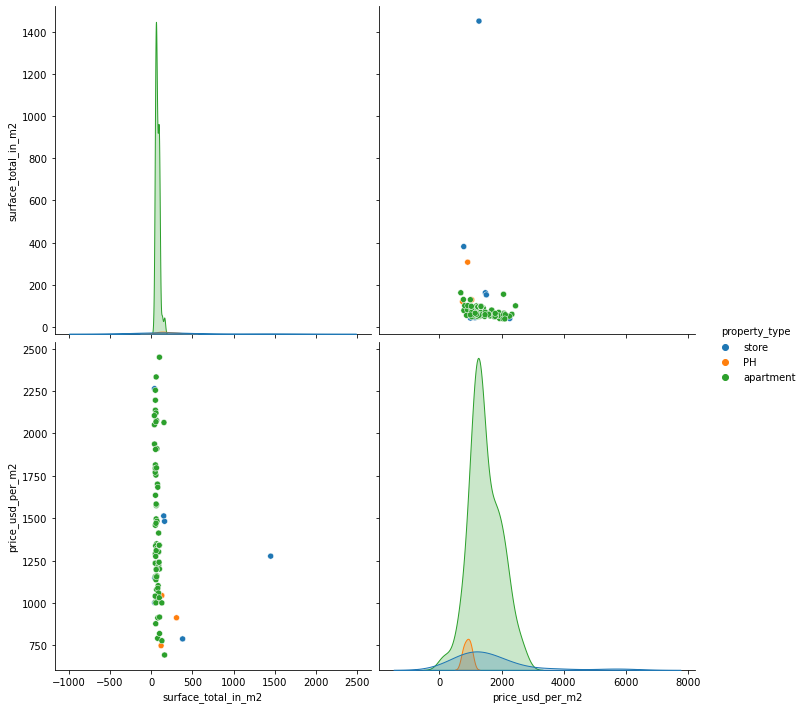

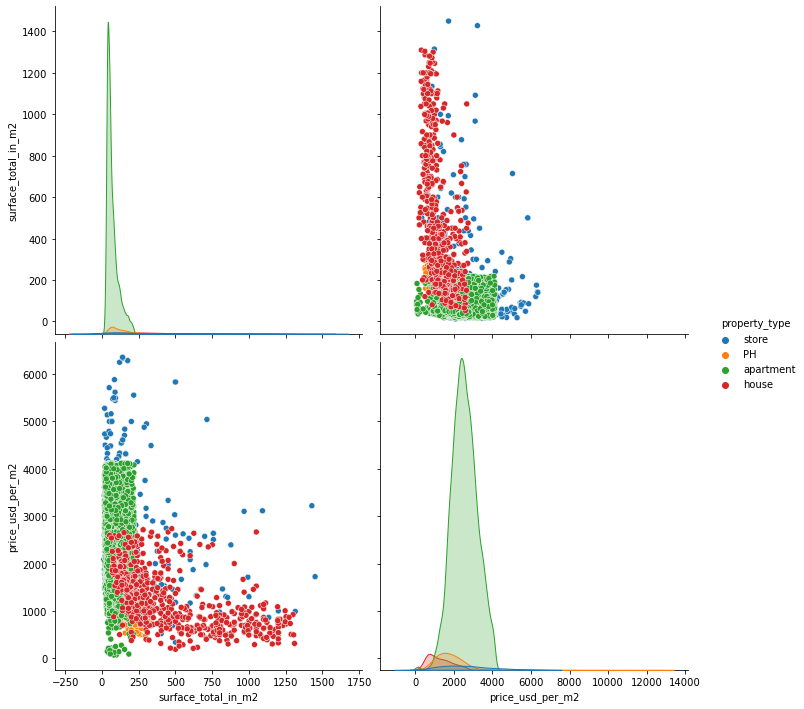

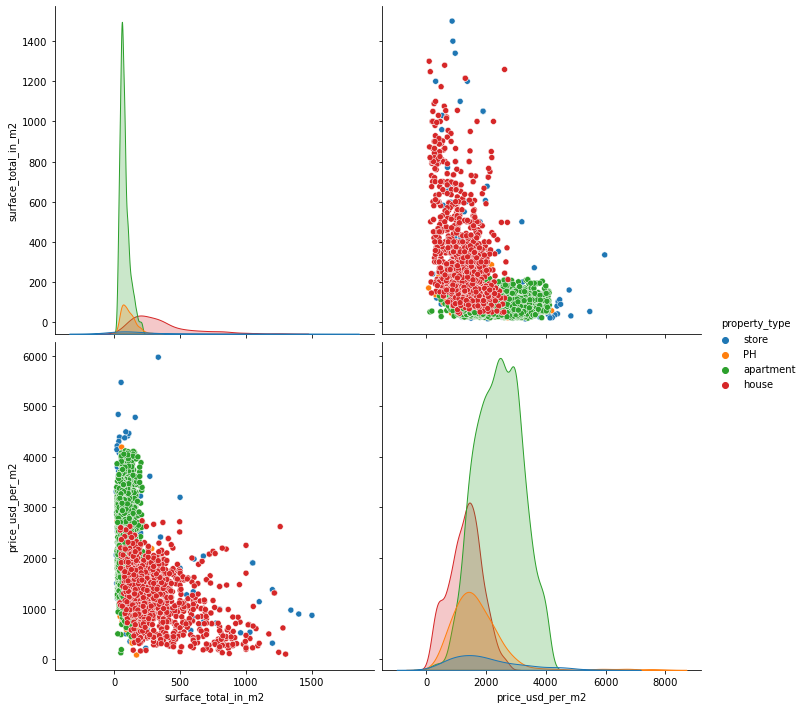

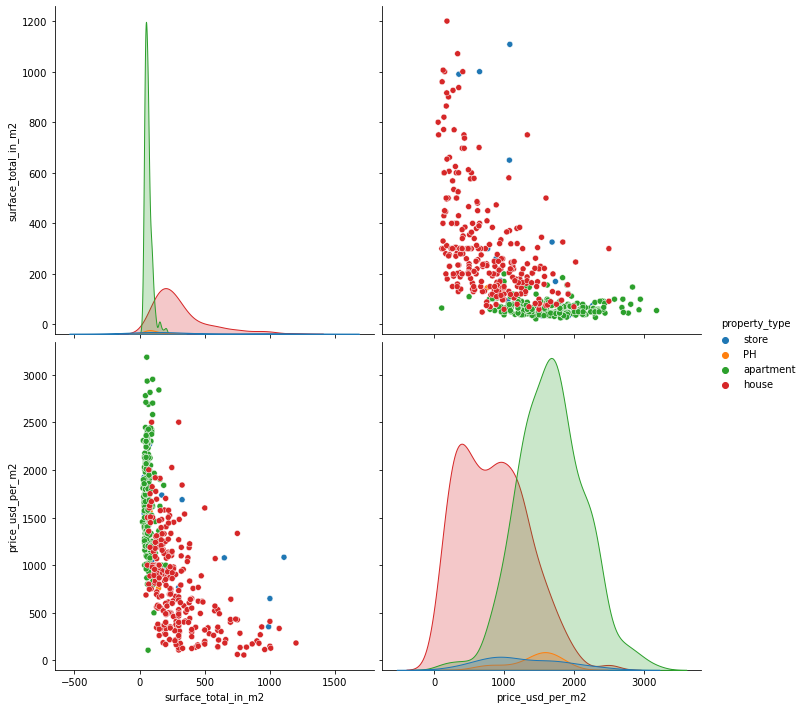

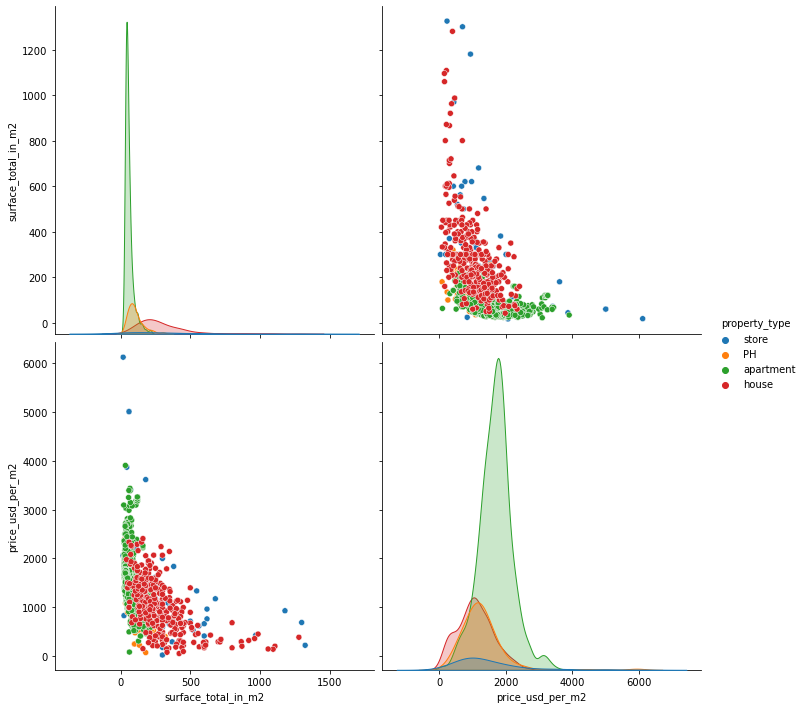

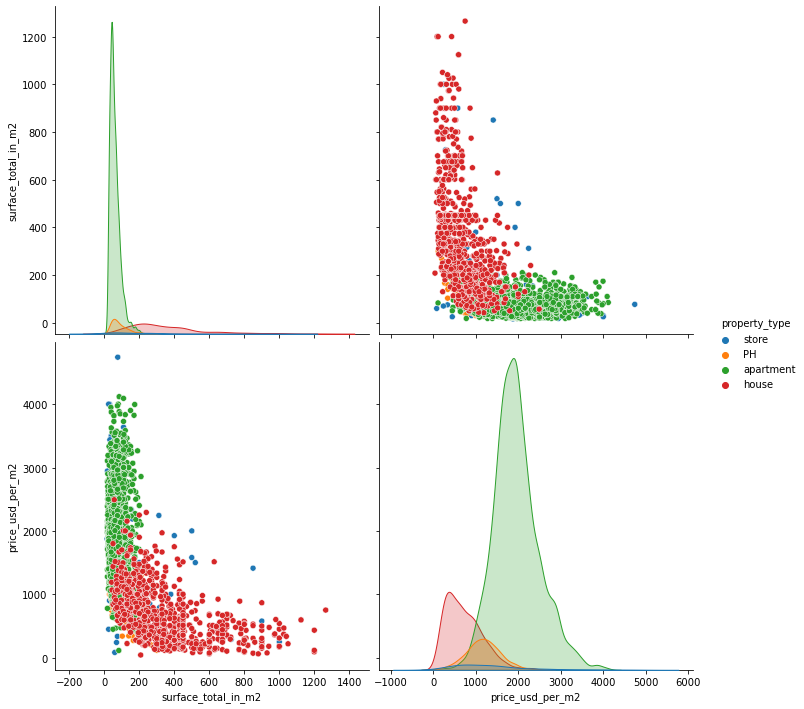

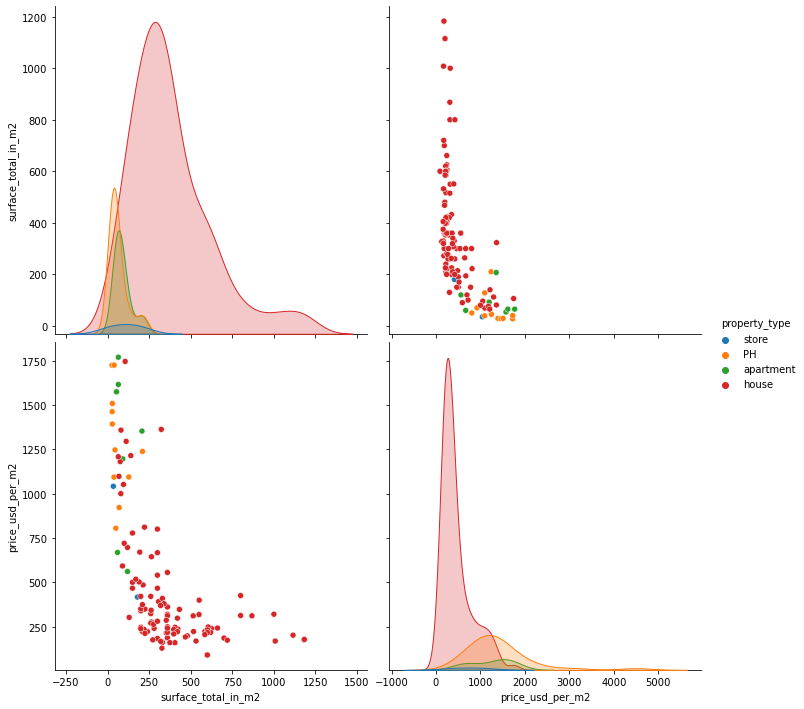

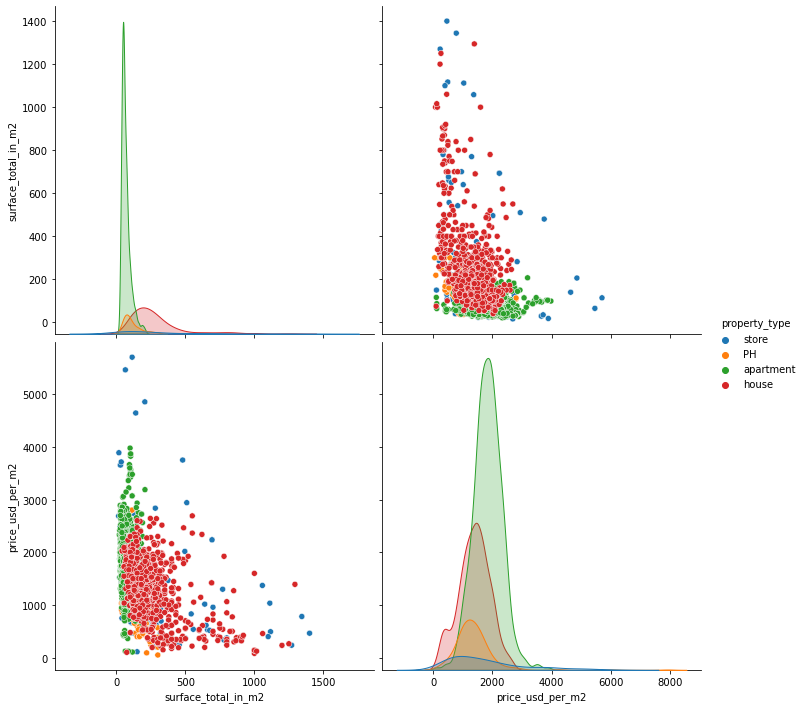

In [19]:
set_check = set(list(data.state_name))
set_check_2 = set(list(data.property_type))

for ix, state in enumerate(set_check): # normalizacion y graficacion
    mascara = data.state_name == state
    for elemento in set_check_2:
        data.loc[mascara, 'price_usd_per_m2'].loc[data.property_type ==elemento] = data.loc[mascara, 'price_usd_per_m2'].loc[data.property_type ==elemento] / (data.loc[mascara, 'price_usd_per_m2'].loc[data.property_type ==elemento]).max()
        data.loc[mascara, 'surface_total_in_m2'].loc[data.property_type ==elemento] = data.loc[mascara, 'surface_total_in_m2'].loc[data.property_type ==elemento] / (data.loc[mascara, 'surface_total_in_m2'].loc[data.property_type ==elemento]).max()
    print (list(set_check)[ix])
    sns.pairplot(data.loc[mascara,['surface_total_in_m2', 'price_usd_per_m2','property_type']], hue='property_type', size=5)

In [20]:
data

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,surface_covered_price_index
19812,store,Mataderos,Capital Federal,169000.000000,USD,305.0,150.0,554.098361,2.033333
31325,store,Mataderos,Capital Federal,100000.000000,USD,115.0,115.0,869.565217,1.000000
31625,store,Mataderos,Capital Federal,230000.000000,USD,298.0,98.0,771.812081,3.040816
60436,store,Mataderos,Capital Federal,420000.000000,USD,407.0,407.0,1031.941032,1.000000
63276,store,Mataderos,Capital Federal,50000.000000,USD,NaN,20.0,2500.000000,1.000000
...,...,...,...,...,...,...,...,...,...
53317,house,Tres Arroyos,Buenos Aires Interior,56674.884562,USD,271.0,75.0,206.950812,3.651424
58474,house,Tres Arroyos,Buenos Aires Interior,250000.000000,USD,390.0,196.0,641.025641,1.989796
59940,house,Tres Arroyos,Buenos Aires Interior,250000.000000,USD,390.0,196.0,641.025641,1.989796
59941,house,Tres Arroyos,Buenos Aires Interior,85000.000000,USD,150.0,100.0,566.666667,1.500000


In [ ]:
data[data.state_name=='Bs.As. G.B.A. Zona Norte'].property_type.value_counts()

In [ ]:
lista_marker = ['o','.',',','x','+','v','^', '<', '>', 's', 'd']

#fig_kw = dict(autoscalex_on= True)
fig, ax = plt.subplots(2, figsize = (10,4))#,**fig_kw)

for i, elemento in enumerate(list(data.state_name.unique())):
    x = data[data.state_name==elemento].surface_total_in_m2
    y = data[data.state_name==elemento].state_name
    #ax[1].plot(x, y, lista_marker[i], label='{}= {}'.format(elemento, lista_marker[i]))
    #plt.legend(numpoints=1)
    ax[0] = plt.axes()
    ax[0].set(xlabel='surface_total_in_m2', ylabel='state_name')
    ax[0].plot(x, y, lista_marker[i], label='{}'.format(elemento))
    ax[0].axis='equal'
    #####ax[0].set_xticks(ticks=[], minor=True)
    leg = ax[0].legend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1)#frameon=False)
    #ax[0].legend(numpoints=1)
plt.show()

#fig, ax = plt.subplots(2, figsize = (10,4))
for i, elemento in enumerate(list(data.state_name.unique())):
    x = data[data.state_name==elemento].price_usd_per_m2
    y = data[data.state_name==elemento].state_name
    ax[1] = plt.axes()
    ax[1].set(xlabel='price_usd_per_m2', ylabel='state_name')
    ax[1]
    ax[1].plot(data[data.state_name==elemento].price_usd_per_m2, data[data.state_name==elemento].state_name, lista_marker[i], label='{}= {}'.format(elemento, lista_marker[i]))
    #plt.legend(numpoints=1)

    
plt.show()

In [ ]:
x1 = data[data.property_type == 'apartment']
x2 = data[data.property_type == 'house']
x3 = data[data.property_type == 'store']
x4 = data[data.property_type == 'PH']

sns.set()
fig = plt.figure(figsize=(16,6))

kwargs= dict(title='histograma surface_total_in_m2 x tipo de propiedad', xlabel='surface_total_in_m2', ylabel='count')#xlim=(0,2500)
ax[0] = plt.axes(**kwargs)

kwargs = dict(histtype='stepfilled', alpha=0.3, bins='auto', align='mid')
ax[0].hist(x1.surface_total_in_m2, color='green', label='apartment', density=True, **kwargs)
ax[0].hist(x2.surface_total_in_m2, color='gold', label='house', density=True, **kwargs)
ax[0]=plt.hist(x3.surface_total_in_m2, color='blue', label='store', density=True, **kwargs);
ax[0]= plt.hist(x4.surface_total_in_m2, color='red', label='PH', density=True, **kwargs);
plt.legend();
plt.show()

fig = plt.figure(figsize=(16,6))

kwargs= dict(title='histograma price_usd_per_m2 x tipo de propiedad', xlabel='price_usd_per_m2', ylabel='count')# yscale='log', , xlim=(0,10000)
ax[1] = plt.axes(**kwargs)

kwargs = dict(histtype='stepfilled', alpha=0.3, bins='auto', align='mid')
ax[1] =plt.hist(x1.price_usd_per_m2, color='green', label='apartment', density=True, **kwargs)
ax[1] =plt.hist(x2.price_usd_per_m2, color='gold', label='house', density=True, **kwargs)
ax[1] =plt.hist(x3.price_usd_per_m2, color='blue', label='store', density=True, **kwargs);
ax[1] =plt.hist(x4.price_usd_per_m2, color='red', label='PH', density=True, **kwargs);
plt.legend();

plt.show()

In [ ]:
x1 = data[data.property_type == 'apartment']
x2 = data[data.property_type == 'house']
x3 = data[data.property_type == 'store']
x4 = data[data.property_type == 'PH']

sns.set(style = 'whitegrid')
fig = plt.figure(figsize=(16,6))

kwargs= dict(title='histograma surface_total_in_m2 x tipo de propiedad', xlabel='surface_total_in_m2', yscale='log', ylabel='count')#xlim=(0,2500), 
ax[0] = plt.axes(**kwargs)

kwargs = dict(histtype='stepfilled', alpha=0.3, bins='auto', align='mid')
ax[0].hist(x1.surface_total_in_m2, color='green', label='apartment', **kwargs)#, density=True
ax[0].hist(x2.surface_total_in_m2, color='gold', label='house', **kwargs)
ax[0]=plt.hist(x3.surface_total_in_m2, color='blue', label='store', **kwargs);
ax[0]= plt.hist(x4.surface_total_in_m2, color='red', label='PH', **kwargs);
plt.legend();
plt.show()

fig = plt.figure(figsize=(16,6))

kwargs= dict(title='histograma price_usd_per_m2 x tipo de propiedad', xlabel='price_usd_per_m2', yscale='log', ylabel='count') #, xlim=(0,20000)
ax[1] = plt.axes(**kwargs)

kwargs = dict(histtype='stepfilled', alpha=0.3, bins='auto', align='mid')
ax[1] =plt.hist(x1.price_usd_per_m2, color='green', label='apartment', density=True, **kwargs)
ax[1] =plt.hist(x2.price_usd_per_m2, color='gold', label='house', density=True, **kwargs)
ax[1] =plt.hist(x3.price_usd_per_m2, color='blue', label='store', density=True, **kwargs);
ax[1] =plt.hist(x4.price_usd_per_m2, color='red', label='PH', density=True, **kwargs);
plt.legend();

plt.show()

In [ ]:
col = [data.property_type == 'apartment', data.property_type == 'house', data.property_type == 'store', data.property_type == 'PH']
sns.set()

for mascara in col:
    sns.kdeplot(data[mascara].price_usd_per_m2, shade=True)

In [ ]:
#help(plt.axes);
#help(plt.figure);
#help(axes.set_xticks);
#help(sns.FacetGrid.map_dataframe);
#help(sns.FacetGrid.map);
#help(plt.hist)
#help(sns.kdeplot)
help(sns.pairplot)
#help(sns.set)

In [ ]:
error
# 9 MODULO DE VISUALIZACION NANS, BOXPLOT Y SCATTERPLOT
print ('\n', '='*40,'pct_nan: porcentaje nans en cada columna','='*40)
df = pd.DataFrame(Dicto['data_cruda'][0])
fig, ax = plt.subplots(figsize=(22, 6))
ax.grid(axis='x')
axes= plt.gca()
axes.set_xlim(0,100)
plt.barh(df.columna, df.pct_nan, label='porcentaje de NaN\'s')

df = pd.DataFrame(Dicto['limpieza_1'][0])
fig, ax = plt.subplots(figsize=(22, 6))
ax.grid(axis='x')
axes= plt.gca()
axes.set_xlim(0,100)
plt.barh(df.columna, df.pct_nan, label='porcentaje de NaN\'s')

df = pd.DataFrame(Dicto['data5'][0])
fig, ax = plt.subplots(figsize=(22, 6))
ax.grid(axis='x')
axes= plt.gca()
axes.set_xlim(0,100)
plt.barh(df.columna, df.pct_nan, label='porcentaje de NaN\'s')

df = pd.DataFrame(Dicto['data7'][0])
print ('\n', '='*40,'pct_nan: porcentaje nans en cada columna','='*40)
fig, ax = plt.subplots(figsize=(22, 6))
ax.grid(axis='x')
axes= plt.gca()
axes.set_xlim(0,100)
plt.barh(df.columna, df.pct_nan, label='porcentaje de NaN\'s')

In [ ]:
# 9 MODULO DE COLUMNAS CATEGORICAS
#data['pct_price'] = data.price/ (data.price_usd_per_m2 * data.surface_total_in_m2)
#data['pct_price'].describe()
data = pd.DataFrame(Dicto['data7'][1])

data['pct_price'] = data.price/ (data.price_usd_per_m2 * data.surface_total_in_m2)
data['pct_price'].describe()

print ()

data = pd.DataFrame(Dicto['data7'][1])

data['pct_price'] = data.price/ (data.price_usd_per_m2 * data.surface_covered_in_m2)
data['pct_price'].describe()


#data[data.surface_total_in_m2.notna()].state_name.value_counts()

In [ ]:
# 10 MODULO DE EXPLORACION ESTADISTICA: SURFACE_COVERED
pd.DataFrame(Dicto['data5'][0])
Dicto.keys()

In [ ]:
# 11 MODULO DE LIMPIEZA SURFACE_COVERED

In [ ]:
# 12 MODULO DE EXPLORACION ESTADISTICA: PRICE_USD_PER_M2

In [ ]:
# 13 MODULO DE LIMPIEZA PRICE_USD_PER_M2

In [ ]:
# 14 MODULO DE CREACION DE SUBCONJUNTO data info y explore del criterio
4 datasets uno por tipo de propiedad
1 dataset armado con un primer criterio